## 데이터 검증의 중요성

**부정확하거나 일관되지 않은 라벨:**
- 라벨의 오류는 모델의 성능을 저하시킬 수 있습니다. 모델이 잘못된 라벨을 학습하면, 정확성, 정밀도, 재현율과 같은 성능 지표가 모두 감소하게 됩니다.

**왜곡된 라벨링:**  
- 라벨이 실제 시나리오를 제대로 대표하지 못할 경우, 모델은 새로운 데이터에 대해 일반화하지 못할 위험이 있습니다. 이는 모델이 실제 환경에서 예측 성능이 떨어지게 만드는 주요 원인이 됩니다.

**비용 문제:**
- 모델 학습 후에 잘못된 라벨을 수정하는 것은 많은 시간과 계산 리소스를 필요로 합니다. 사전에 정확한 라벨링을 보장하는 것이 훨씬 더 비용 효율적입니다.

**편향 문제:**  
- 일관되지 않거나 부정확한 라벨링은 모델에 편향을 초래할 수 있습니다. 이는 특정 그룹이나 시나리오에 대해 모델이 불공평하거나 비효율적인 결정을 내리는 결과를 초래할 수 있습니다.

**디버깅 어려움:**  
- 라벨링 오류는 모델 디버깅을 더 어렵게 만듭니다. 성능 저하가 모델 아키텍처, 하이퍼파라미터, 혹은 데이터 자체의 문제로 인한 것인지 구별하기가 힘들어질 수 있습니다.

**신뢰성:**
- 기계 학습 모델의 신뢰성과 효율성은 사용자 신뢰에 매우 중요합니다. 잘못된 라벨이 포함된 데이터는 특히 의료, 금융, 또는 안전이 중요한 시스템에서 모델의 신뢰성을 크게 약화시킬 수 있습니다.

## 라이브러리 import

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from glob import glob
from typing import *
from IPython.display import Image as IPImage
from sklearn.model_selection import train_test_split
import random
import os
import shutil
from PIL import Image as Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import ConcatDataset
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F

In [ ]:
# 코랩에서 GPU 사용을 위해서는 별도의 설정이 필요합니다.
# 상단 런타임 -> 런타임 유형 변경의 항목을 통해 CPU대신 사용 가능한 GPU로 하드웨어 가속기를 변경해줍니다.
# 아래 코드는 GPU 사용이 가능한 상태인지 확인하는 코드로, 올바르게 GPU 설정이 되어있다면 TURE, 1이 출력됩니다.
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


## GPU 환경 설정

In [ ]:
# nivida-smi 명령어를 통해 할당된 GPU의 정보에 대해 확인할 수 있습니다.
!nvidia-smi

Wed Nov 29 07:59:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:0F:00.0 Off |                    0 |
| N/A   39C    P0    37W / 300W |     14MiB / 32508MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 랜덤시드 고정

In [ ]:
def seed_everything(seed):
    random.seed(seed)  # Python
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch
    torch.cuda.manual_seed(seed)  # PyTorch cuda
    torch.backends.cudnn.deterministic = True  # CuDNN
    torch.backends.cudnn.benchmark = False  # CuDNN benchmark

In [ ]:
seed_everything(seed=32)

## Google Colab에서 데이터 관리 및 최적 활용 전략

### 드라이브 설정  
- 코랩에서 데이터에 접근하는 방법에는 크게 두 가지가 있습니다.
  - 1. 구글 드라이브 연동 : 자신의 Google Drive를 코랩에 연결하여 드라이브 안의 데이터에 접근합니다.   
  - 2. 코랩의 세션 드라이브 업로드 : 코랩의 임시 저장 공간에 데이터를 업로드하여 사용합니다.

- 각각의 방법은 장단점을 가지고 있습니다.
- 구글 드라이브 연동의 장점은 드라이브에 데이터가 미리 준비되어 있으면 즉시 사용할 수 있다는 것이며, 데이터가 지속적으로 보존됩니다. 단점은 이미지 데이터와 같이 용량이 큰 데이터를 다룰 때, 로딩 속도가 매우 느리다는 단점이 있습니다.  
- 코랩의 세션 드라이브에 업로드하는 방법의 장점은 드라이브 연동에 비해 로딩 속도를 매우 빠르게 사용할 수 있다는 것입니다. 하지만 이 방법의 단점은 코랩 런타임이 초기화될 때마다 데이터가 사라지고, 다른 ipynb에서 접근이 안된다는 단점이 존재합니다.

- 따라서 이미지 데이터와 같이 대용량의 학습 데이터는 학습 직전에 임시 경로에 업로드하여 사용하고, 그 외 필요한 파일들은 구글 드라이브에서 직접 불러오는 것이 좋습니다. 또한 학습된 모델 파일처럼 저장이 필요한 자료는 보존을 위해 반드시 구글 드라이브에 저장합니다. 이렇게 하면 데이터 사용의 효율성과 접근성을 극대화할 수 있습니다.

## 데이터셋 로드

In [ ]:
# 작업 환경의 현재 경로를 확인합니다.
os.getcwd()

'/content'

## 코랩의 세션 드라이브에 데이터 업로드

In [ ]:
import gdown

# Google Drive 파일 ID와 URL 설정
file_id = "1U7vCDZ4X9ElceQvBllL8ccGHXHjc1qTw"
url = f"https://drive.google.com/uc?id={file_id}"

# 다운로드할 파일 이름 설정
output = "OCR_ResNet18_dataset.zip"

# gdown을 사용하여 파일 다운로드
gdown.download(url, output, quiet=False)

print(f"파일 다운로드가 완료되었습니다: {output}")

Downloading...
From (original): https://drive.google.com/uc?id=1U7vCDZ4X9ElceQvBllL8ccGHXHjc1qTw
From (redirected): https://drive.google.com/uc?id=1U7vCDZ4X9ElceQvBllL8ccGHXHjc1qTw&confirm=t&uuid=213ebd5e-b908-4884-a0fc-fcc4cf26a37d
To: /content/OCR_ResNet18_dataset.zip
100%|██████████| 82.9M/82.9M [00:00<00:00, 171MB/s]


파일 다운로드가 완료되었습니다: OCR_ResNet18_dataset.zip


In [ ]:
# unzip 명령어를 통해 압축 파일을 해제해 줍니다.
!unzip -qq OCR_ResNet18_dataset.zip

In [ ]:
# 코랩 드라이브에서 대량의 이미지 파일을 로드할 경우 매우 시간이 오래 걸립니다.
# 따라서 사용할 이미지는 drive 경로(/content/drive)가 아닌 코랩 세션 드라이브(/content/drive 이외의 경로)의 경로에 데이터를 업로드해줍니다.
image_path = "./dataset/digit_data"
asset_path = "./assets"

In [ ]:
# 학습 데이터셋
origin_train_df = pd.read_csv(f"{image_path}/train_data.txt", names=["path"])
origin_train_df["label"] = origin_train_df["path"].str[0].astype(int)
origin_train_df["path"] = image_path + "/" + origin_train_df["path"]
origin_train_df

,path,label
0,./dataset/digit_data/0/00001_3.jpg,0
1,./dataset/digit_data/0/00001_7.jpg,0
2,./dataset/digit_data/0/00002_3.jpg,0
3,./dataset/digit_data/0/00003_3.jpg,0
4,./dataset/digit_data/0/00003_7.jpg,0
...,...,...
21784,./dataset/digit_data/9/03817_2.jpg,9
21785,./dataset/digit_data/9/03817_5.jpg,9
21786,./dataset/digit_data/9/03857_1.jpg,9
21787,./dataset/digit_data/9/03857_5.jpg,9


In [ ]:
# 테스트 데이터셋 (valid_data.txt지만 미리 나눠진 test set으로 사용하도록 하겠음)
test_df = pd.read_csv(f"{image_path}/valid_data.txt", names=["path"])
test_df["label"] = test_df["path"].str[0].astype(int)
test_df["path"] = image_path + "/" + test_df["path"]
test_df

,path,label
0,./dataset/digit_data/0/00004_1.jpg,0
1,./dataset/digit_data/0/00006_3.jpg,0
2,./dataset/digit_data/0/00007_3.jpg,0
3,./dataset/digit_data/0/00009_1.jpg,0
4,./dataset/digit_data/0/00011_7.jpg,0
...,...,...
5443,./dataset/digit_data/9/03786_1.jpg,9
5444,./dataset/digit_data/9/03814_1.jpg,9
5445,./dataset/digit_data/9/03817_1.jpg,9
5446,./dataset/digit_data/9/03817_6.jpg,9


## Train/Valid/Test 데이터셋 분리

kamp데이터는 train/valid 밖에 구분되어 있지 않지만

저희는 보다 명확한 검토를 위해

    train => train/valid

    valid = > test
    
로 사용하도록 하겠습니다

In [ ]:
# train 데이터셋을 8:2로 나눠서 valid를 하도록 하겠습니다
train_df, valid_df = train_test_split(
    origin_train_df,
    test_size=0.2,
    random_state=0,
    shuffle=True,
    stratify=origin_train_df["label"],
)


## DataSet, DataLoader 생성
PyTorch에서 torch.utils.data.Dataset 클래스를 사용하는 이유:
1. 데이터 관리의 일관성
Dataset 클래스를 사용하면 데이터를 일관된 방식으로 관리할 수 있습니다. 데이터 로드, 전처리, 샘플링을 위한 구조를 명확히 정의할 수 있어 코드 유지보수가 용이합니다. raw 데이터를 직접 사용하면 데이터를 불러오는 로직이 코드 곳곳에 흩어질 수 있습니다.
Dataset 클래스는 데이터 관련 로직을 캡슐화하여 재사용성을 높이고 코드 가독성을 향상시킵니다.

2. 효율적인 데이터 로드
Dataset 클래스는 DataLoader와 함께 사용되어 배치 처리 및 병렬 데이터 로드를 지원합니다.raw 데이터를 직접 사용하면 배치 처리를 수동으로 구현해야 하며, 효율적이지 않을 수 있습니다.
DataLoader는 Dataset에서 배치를 자동으로 생성하고, 멀티스레딩을 통해 데이터 로드 속도를 높입니다.

3. 동적인 데이터 전처리
Dataset 클래스의 핵심은 __getitem__과 __len__ 메서드를 커스터마이징할 수 있다는 점입니다. 데이터를 로드하는 동시에 필요한 전처리(예: 텍스트 토크나이징, 이미지 변환 등)를 수행할 수 있습니다.
raw 데이터를 직접 사용하면 데이터 전처리를 별도의 단계에서 처리해야 하므로 유연성이 떨어집니다.

4. 메모리 관리
Dataset은 필요할 때 데이터를 로드하는 방식을 지원합니다(예: Lazy Loading).
raw 데이터를 한꺼번에 메모리에 올리면 큰 데이터셋의 경우 메모리 부족 문제가 발생할 수 있습니다.
Dataset 클래스는 데이터를 필요할 때만 로드하거나 스트리밍 방식으로 처리하여 메모리 사용량을 최소화할 수 있습니다.

5. 확장성
사용자가 직접 데이터 구조를 정의하고 커스터마이징할 수 있습니다.
raw 데이터는 구조적으로 고정되어 있어 추가적인 기능(예: 샘플링, 데이터 증강 등)을 구현하기 어렵습니다.
Dataset을 상속받아 자신만의 데이터셋 클래스를 만들어 다양한 데이터 소스와 처리 방법을 통합할 수 있습니다.

In [ ]:
# 사용자 정의 데이터셋 클래스 생성 (CustomDataset)
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        # 데이터셋 초기화
        # dataframe: 이미지 경로와 레이블이 포함된 데이터프레임
        # transform: 이미지에 적용할 전처리(transform) 함수
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        # 데이터셋의 총 샘플 수 반환
        return len(self.dataframe)

    def __getitem__(self, idx):
        # 주어진 인덱스(idx)에 해당하는 샘플을 반환
        # 이미지 경로를 데이터프레임에서 가져옴
        img_name = self.dataframe.iloc[idx, 0]
        # 이미지 파일을 열고 RGB 모드로 변환
        img = Image.open(img_name).convert('RGB')
        # 레이블 정보를 정수형으로 가져옴
        label = int(self.dataframe.iloc[idx, 1])

        # transform이 지정되어 있다면 이미지에 전처리를 적용
        if self.transform:
            img = self.transform(img)

        # 이미지와 레이블을 반환
        return img, label

In [ ]:
'''
아래는 이미지 데이터셋의 각 RGB 채널에 대해 전체적인 평균(mean)과 표준 편차(standard deviation, std)를 계산하는 코드입니다.
이 작업은 데이터 전처리 과정에서 매우 중요한데, 다음과 같은 목적이 있습니다.

데이터 정규화 (Normalization): 딥러닝 모델에서 이미지를 입력으로 사용할 때, 입력 데이터의 스케일링을 동일하게 하는 것이 중요합니다.
각 픽셀 값에서 채널별 평균을 빼고, 표준 편차로 나누어서 픽셀 값의 분포를 정규화할 수 있습니다.
이렇게 함으로써 모델은 더 빠르게 수렴할 수 있고, 다른 데이터셋에 대한 모델의 일반화 능력을 향상시킬 수 있습니다.

데이터 표준화 (Standardization):
데이터셋에 있는 이미지들이 서로 다른 출처에서 오거나 다양한 조명 환경에서 촬영된 경우, 픽셀 값의 분포가 다를 수 있습니다.
표준화 과정을 거치면 이러한 차이를 줄여 모델이 이미지의 구조적인 특성에 더 집중할 수 있게 해줍니다.

모델 입력 요구사항 충족:
많은 딥러닝 모델들, 특히 사전 훈련된 네트워크는 특정 범위의 입력 값을 요구합니다.
예를 들어, 일부 모델은 입력 값으로 0에서 1 사이, 또는 -1에서 1 사이의 값을 요구할 수 있는데,
평균과 표준 편차를 계산하면 이러한 요구사항을 충족시키는 정규화 과정을 쉽게 적용할 수 있습니다.

하지만 해당 코드를 직접 실행하면, 매우 많은 연산량으로 인해 코랩 환경이 다운될 가능성이 높습니다.
보다 좋은 환경에서 직접 실행해 보고, 본 과정에서는 미리 계산된 값으로 이를 대체하겠습니다.
'''

def compute_overall_mean_std(dfs):
    all_pixels = {0: [], 1: [], 2: []}

    for df in dfs:
        for index, row in df.iterrows():
            img_path = row['path']  # 'path' 대신에 실제 경로가 있는 컬럼명을 사용해주세요.
            img = Image.open(img_path)
            img_np = np.array(img)

            for i in range(3): # RGB 채널
                channel_pixels = img_np[:, :, i].ravel().tolist()  # 각 채널의 모든 픽셀 값을 수집합니다.
                all_pixels[i].extend(channel_pixels)

    means = [np.mean(all_pixels[i]) for i in range(3)]
    stds = [np.std(all_pixels[i]) for i in range(3)]

    return means, stds


# train_df와 valid_df에 대해서 계산
# 컴퓨팅 자원이 풍부한 환경에서 실행할 경우 직접 실행해볼 수 있습니다.
# channel_means, channel_stds = compute_overall_mean_std([train_df, valid_df])

# 연산량 이슈로 미리 계산해둔 값 사용
channel_means = [193.67807472479592, 111.60517909723688, 118.44033090803525]
channel_stds = [63.00208387441839, 87.1299016633704, 71.00312754293988]

print("Overall Data: Mean -", channel_means, "Std -", channel_stds)

Overall Data: Mean - [193.67807472479592, 111.60517909723688, 118.44033090803525] Std - [63.00208387441839, 87.1299016633704, 71.00312754293988]


In [ ]:
# 채널 평균 및 표준편차를 0~1 사이의 값으로 정규화
normalized_channel_means = [x / 255 for x in channel_means]
normalized_channel_stds = [x / 255 for x in channel_stds]

# 이미지 전처리를 위한 변환 작업 정의.
# transforms.Normalize 이전에 이미 픽셀값은 0~1 사이로 정규화 되어 있습니다.
# 따라서 기존의 0~255 픽셀값 기준에서 도출된 channel_means, channel_stds 도 0~1 사이 값으로 정규화 된 normalized_channel_means, normalized_channel_stds 로 변환하여 사용합니다
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=normalized_channel_means, std=normalized_channel_stds),
])

# 코랩의 GPU 환경은 실행시마다 바뀔 수 있습니다.
# 혹시 메모리 에러가 난다면 batch size를 줄여서 학습을 시도해 볼 수 있습니다.
batch_size = 256

# 데이터셋 로딩
train_dataset = CustomDataset(dataframe=train_df, transform=transform)
valid_dataset = CustomDataset(dataframe=valid_df, transform=transform)
test_dataset = CustomDataset(dataframe=test_df, transform=transform)

# 데이터 로더 설정
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## ResNet 모델 학습

In [ ]:
# 사전 학습된 ResNet18 모델 불러오기
model = models.resnet18(pretrained=True)

# 모델의 마지막 완전 연결 계층(fc)을 사용자 정의 계층으로 대체
# 이 계층은 in_features에서 10개의 출력으로 매핑합니다 (10개 클래스 분류를 위함)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 10),
)

# 교차 엔트로피 손실 함수 초기화
criterion = nn.CrossEntropyLoss()
# 최적화 알고리즘으로 Adam 사용
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 137MB/s]


In [ ]:
# 학습 파라미터 설정
num_epochs = 50  # 학습 반복 횟수
best_val_acc = 0.0  # 최상의 검증 정확도를 저장하는 변수
patience = 5  # 얼리 스탑핑을 위한 patience 설정 (개선되지 않은 횟수)
no_improve = 0  # 개선되지 않은 에포크 수를 카운트하는 변수

for epoch in range(num_epochs):

    # 모델을 학습 모드로 전환
    model.train()
    running_loss = 0.0  # 에포크 동안의 총 손실을 저장하는 변수
    correct_train = 0  # 정확하게 예측한 학습 데이터의 개수를 저장하는 변수
    total_train = 0  # 총 학습 데이터 개수를 저장하는 변수

    # 학습 데이터를 반복하여 모델 업데이트
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", dynamic_ncols=True):
        # 데이터를 장치로 이동 (GPU 또는 CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # 옵티마이저의 기울기 초기화
        optimizer.zero_grad()
        # 모델에 입력을 전달하여 예측값 출력
        outputs = model(inputs)
        # 손실 함수 계산
        loss = criterion(outputs, labels)
        # 손실에 대한 역전파 수행 (기울기 계산)
        loss.backward()
        # 옵티마이저를 통해 모델 파라미터 업데이
        optimizer.step()
        # 현재 배치의 손실을 누적
        running_loss += loss.item()

        # 정확도 계산을 위한 예측값 처리
        _, predicted = torch.max(outputs.data, 1) # 최대값을 가지는 클래스 예측
        total_train += labels.size(0) # 총 학습 데이터 수 누적
        correct_train += (predicted == labels).sum().item() # 맞춘 예측의 개수 누적

    # 에포크별 학습 정확도와 손실 계산
    train_acc = correct_train / total_train
    train_loss = running_loss / len(train_loader)

    # Validate
    model.eval()  # 모델을 평가 모드로 전환 (드롭아웃, 배치 정규화 등 비활성화)
    running_val_loss = 0.0  # 검증 손실을 저장하는 변수
    correct_val = 0  # 정확하게 예측한 검증 데이터의 개수를 저장하는 변수
    total_val = 0  # 총 검증 데이터 개수를 저장하는 변수
    with torch.no_grad(): # 검증 시에는 기울기를 계산하지 않음 (메모리 및 계산량 절약)
        for inputs, labels in valid_loader:
            # 데이터를 장치로 이동
            inputs, labels = inputs.to(device), labels.to(device)
            # 모델에 입력을 전달하여 예측값 출력
            outputs = model(inputs)
            # 손실 함수 계산
            loss = criterion(outputs, labels)
            # 현재 배치의 손실을 누적
            running_val_loss += loss.item()

            # 정확도 계산을 위한 예측값 처리
            _, predicted = torch.max(outputs.data, 1)  # 최대값을 가지는 클래스 예측
            total_val += labels.size(0)  # 총 검증 데이터 수 누적
            correct_val += (predicted == labels).sum().item()  # 맞춘 예측의 개수 누적

    # 에포크별 검증 정확도와 손실 계산
    val_acc = correct_val / total_val  # 검증 정확도 계산
    val_loss = running_val_loss / len(valid_loader)  # 검증 손실 평균 계산

    # 학습 및 검증 결과 출력
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

     # 최상의 검증 정확도를 기록하고 모델 저장
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model_before.pth')
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:  # 설정한 얼리 스타핑 patience에 도달하면 학습을 중단합니다.
            print("Early stopping")
            break

print('Finished Training')

## best model load

In [ ]:
model.load_state_dict(torch.load('best_model_before.pth'))
model.eval()

## 오차 데이터 분석 - mis label 확인
- 높은 confidence로 예측 했으나, class가 다를 시 해당 데이터의 라벨링이 잘못 되었는지 확인이 필요합니다.

In [ ]:
all_df = pd.concat([origin_train_df,test_df])

# 잘못 예측된 이미지와 라벨을 저장할 리스트
mismatched_images = []

# Softmax 함수 초기화 (확률 값으로 변환하기 위함)
softmax = nn.Softmax(dim=1)

# 모델을 GPU로 이동
model = model.to('cuda')  # 만약 사용 가능한 GPU가 있다면.

for index,(img_path,true_label) in tqdm(all_df.iterrows()):

    # Load and preprocess the image
    image = Image.open(img_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0)

    # 입력 텐서를 GPU로 이동
    input_tensor = input_tensor.to('cuda')  # 만약 사용 가능한 GPU가 있다면.

    # Get model outputs
    with torch.no_grad():
        logits = model(input_tensor)

    # Softmax를 사용하여 확률로 변환
    probabilities = softmax(logits)

    # 가장 높은 확률을 가진 라벨과 그 확률을 추출
    max_prob, predicted_label = torch.max(probabilities, 1)

     # 예측된 라벨이 실제 라벨과 다르고, 확률이 0.90보다 높은 경우 리스트에 추가
    if predicted_label.cpu().item() != true_label and max_prob.item() > 0.90:
        mismatched_images.append((img_path, true_label))

27237it [04:09, 108.98it/s]


## label mistakenness 확인
- 높은 confidence로 예측 했으나, class가 다를 시, 해당 데이터의 라벨링이 잘못 되었는지 확인이 필요합니다.

./dataset/digit_data/0/00247_0.jpg 0


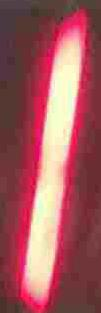

./dataset/digit_data/0/00411_4.jpg 0


./dataset/digit_data/0/00548_0.jpg 0


./dataset/digit_data/0/00642_4.jpg 0


./dataset/digit_data/0/00832_4.jpg 0


./dataset/digit_data/0/02819_2.jpg 0


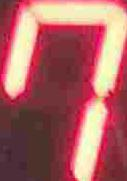

./dataset/digit_data/1/02701_3.jpg 1


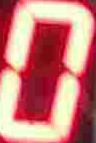

./dataset/digit_data/2/00140_4.jpg 2


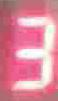

./dataset/digit_data/2/00251_6.jpg 2


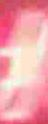

./dataset/digit_data/2/00673_1.jpg 2


./dataset/digit_data/2/00767_5.jpg 2


./dataset/digit_data/2/00978_4.jpg 2


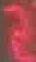

./dataset/digit_data/2/02489_3.jpg 2


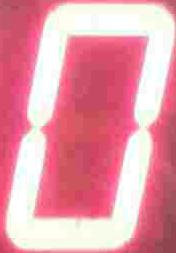

./dataset/digit_data/3/02282_0.jpg 3


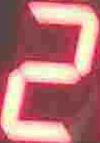

./dataset/digit_data/4/00626_1.jpg 4


./dataset/digit_data/5/00150_2.jpg 5


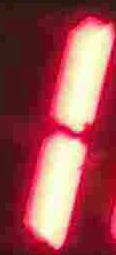

./dataset/digit_data/5/00268_0.jpg 5


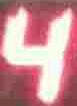

./dataset/digit_data/5/01557_5.jpg 5


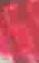

./dataset/digit_data/5/01868_6.jpg 5


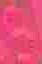

./dataset/digit_data/5/02526_5.jpg 5


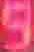

./dataset/digit_data/5/03525_3.jpg 5


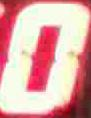

./dataset/digit_data/6/00064_5.jpg 6


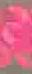

./dataset/digit_data/6/00617_6.jpg 6


./dataset/digit_data/6/02063_5.jpg 6


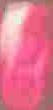

./dataset/digit_data/7/01186_6.jpg 7


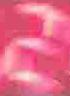

./dataset/digit_data/8/00164_2.jpg 8


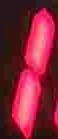

./dataset/digit_data/8/00239_5.jpg 8


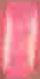

./dataset/digit_data/8/00826_6.jpg 8


./dataset/digit_data/8/01567_7.jpg 8


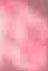

./dataset/digit_data/0/00527_0.jpg 0


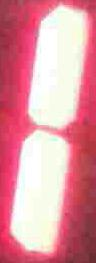

./dataset/digit_data/0/00744_4.jpg 0


./dataset/digit_data/1/01141_6.jpg 1


./dataset/digit_data/1/02206_6.jpg 1


./dataset/digit_data/2/00025_3.jpg 2


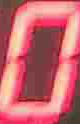

./dataset/digit_data/3/02534_5.jpg 3


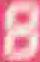

./dataset/digit_data/5/00170_2.jpg 5


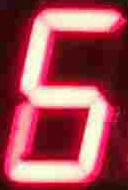

./dataset/digit_data/5/03605_4.jpg 5


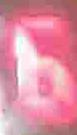

./dataset/digit_data/6/01340_6.jpg 6


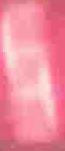

./dataset/digit_data/7/00895_3.jpg 7


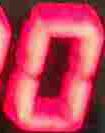

./dataset/digit_data/8/02076_3.jpg 8


./dataset/digit_data/9/01117_4.jpg 9


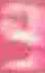

In [ ]:
for path,label in mismatched_images:
    print(path, label)
    img = Image.open(path)
    img.show()

## 잘못된 라벨 수정
- 시각화를 해보니 잘못 라벨링이 된 항목들이 몇 개 보입니다.
- confidence가 높은 오답을 시각화 했을 때, 육안으로 구분 가능한 잘못된 라벨들이 포함되어 있음을 알 수 있습니다
- 모델의 성능 향상을 위해 라벨을 수정하여 줍니다 (가능한 만큼)

In [ ]:
# label_index : 라벨을 뜻하는 폴더명의 위치 (split 할 경우)
def move_data(filename: str, label: int, label_index=3):
    moved_paths = []
    for path1 in glob(f"{image_path}/*/{filename}"):
        divided = path1.split("/")
        divided[label_index] = str(label)
        path2 = "/".join(divided)
        if path1 != path2:
            shutil.move(path1, path2)
            print(f"{path1} => {path2}")
            moved_paths.append((path1, path2))
    return moved_paths

In [ ]:
image_changes = [
    ("00247_0.jpg", 1),
    ("00642_4.jpg", 3),
    ("02819_2.jpg", 7),
    ("02701_3.jpg", 0),
    ("00140_4.jpg", 3),
    ("02489_3.jpg", 0),
    ("02574_7.jpg", 0),
    ("02282_0.jpg", 2),
    ("00626_1.jpg", 1),
    ("01561_0.jpg", 5),
    ("00150_2.jpg", 1),
    ("00268_0.jpg", 4),
    ("03525_3.jpg", 0),
    ("00617_6.jpg", 1),
    ("00164_2.jpg", 1),
    ("00527_0.jpg", 1),
    ("00025_3.jpg", 0),
    ("02534_5.jpg", 8),
    ("00895_3.jpg", 0),
    ("02334_0.jpg", 2),
    ("00411_4.jpg", 3),
    ("01186_6.jpg", 2),
]

In [ ]:
moved_paths = []

# image_changes 리스트를 기반으로 이미지 데이터 이동
for img_file, new_label in image_changes:
    moved_paths.extend(move_data(img_file, new_label))

./dataset/digit_data/0/00247_0.jpg => ./dataset/digit_data/1/00247_0.jpg
./dataset/digit_data/0/00642_4.jpg => ./dataset/digit_data/3/00642_4.jpg
./dataset/digit_data/0/02819_2.jpg => ./dataset/digit_data/7/02819_2.jpg
./dataset/digit_data/1/02701_3.jpg => ./dataset/digit_data/0/02701_3.jpg
./dataset/digit_data/2/00140_4.jpg => ./dataset/digit_data/3/00140_4.jpg
./dataset/digit_data/2/02489_3.jpg => ./dataset/digit_data/0/02489_3.jpg
./dataset/digit_data/2/02574_7.jpg => ./dataset/digit_data/0/02574_7.jpg
./dataset/digit_data/3/02282_0.jpg => ./dataset/digit_data/2/02282_0.jpg
./dataset/digit_data/4/00626_1.jpg => ./dataset/digit_data/1/00626_1.jpg
./dataset/digit_data/4/01561_0.jpg => ./dataset/digit_data/5/01561_0.jpg
./dataset/digit_data/5/00150_2.jpg => ./dataset/digit_data/1/00150_2.jpg
./dataset/digit_data/5/00268_0.jpg => ./dataset/digit_data/4/00268_0.jpg
./dataset/digit_data/5/03525_3.jpg => ./dataset/digit_data/0/03525_3.jpg
./dataset/digit_data/6/00617_6.jpg => ./dataset/dig

In [ ]:
changes_dict = {img_name: new_label for img_name, new_label in image_changes}

In [ ]:
def update_labels_txt(txt_path, changes_dict):
    # 함수 설명: 주어진 텍스트 파일(txt_path)의 레이블을 changes_dict에 따라 업데이트합니다.
    # txt_path: 레이블 정보가 저장된 텍스트 파일 경로
    # changes_dict: 이미지 이름을 키로 하고, 변경할 레이블을 값으로 가지는 딕셔너리

    try:
        # 텍스트 파일을 읽기 모드로 열기
        with open(txt_path, 'r') as file:
            data = file.readlines()  # 파일의 모든 라인을 읽어와 리스트로 저장
    except FileNotFoundError:
        # 파일이 존재하지 않을 경우 예외 처리
        print(f"{txt_path} not found.")  # 파일이 없음을 알리는 메시지 출력
        return  # 함수 종료

    # 업데이트된 데이터를 저장할 리스트
    updated_data = []

    # 파일의 각 라인을 반복하면서 레이블을 변경합니다.
    for line in data:
        # 라인에서 이미지 이름 추출 ("/"로 나누어 마지막 부분이 이미지 이름)
        img_name = line.strip().split("/")[-1]

        # changes_dict에 이미지 이름이 있는지 확인
        if img_name in changes_dict:
            # 만약 변경해야 하는 이미지 이름이 있다면, 기존 레이블을 새로운 레이블로 업데이트
            print(f"Updating {img_name}: label {line.strip().split('/')[0]} => {changes_dict[img_name]}")
            # 변경된 레이블과 이미지 이름을 새로운 형식으로 저장
            updated_data.append(f"{changes_dict[img_name]}/{img_name}\n")
        else:
            # 변경할 필요가 없는 경우, 원래의 라인을 그대로 저장
            updated_data.append(line)

    # 업데이트된 데이터를 원래 파일에 덮어쓰기
    try:
        with open(txt_path, 'w') as file:
            file.writelines(updated_data)  # 모든 업데이트된 라인을 파일에 기록
    except IOError:
        # 파일 쓰기 중 에러가 발생할 경우 예외 처리
        print(f"Error writing to {txt_path}.")  # 쓰기 실패 메시지 출력

In [ ]:
# txt 파일 업데이트
train_txt_path = f"{image_path}/train_data.txt"
update_labels_txt(train_txt_path, changes_dict)

Updating 00247_0.jpg: label 0 => 1
Updating 00411_4.jpg: label 0 => 3
Updating 00642_4.jpg: label 0 => 3
Updating 02819_2.jpg: label 0 => 7
Updating 02701_3.jpg: label 1 => 0
Updating 00140_4.jpg: label 2 => 3
Updating 02489_3.jpg: label 2 => 0
Updating 02574_7.jpg: label 2 => 0
Updating 02282_0.jpg: label 3 => 2
Updating 02334_0.jpg: label 3 => 2
Updating 00626_1.jpg: label 4 => 1
Updating 01561_0.jpg: label 4 => 5
Updating 00150_2.jpg: label 5 => 1
Updating 00268_0.jpg: label 5 => 4
Updating 03525_3.jpg: label 5 => 0
Updating 00617_6.jpg: label 6 => 1
Updating 01186_6.jpg: label 7 => 2
Updating 00164_2.jpg: label 8 => 1


In [ ]:
valid_txt_path = f"{image_path}/valid_data.txt"
update_labels_txt(valid_txt_path, changes_dict)

Updating 00527_0.jpg: label 0 => 1
Updating 00025_3.jpg: label 2 => 0
Updating 02534_5.jpg: label 3 => 8
Updating 00895_3.jpg: label 7 => 0


## 수정된 데이터셋 로드

In [ ]:
# 학습 데이터셋
origin_train_df = pd.read_csv(f"{image_path}/train_data.txt", names=["path"])
origin_train_df["label"] = origin_train_df["path"].str[0].astype(int)
origin_train_df["path"] = image_path + "/" + origin_train_df["path"]
origin_train_df

,path,label
0,./dataset/digit_data/0/00001_3.jpg,0
1,./dataset/digit_data/0/00001_7.jpg,0
2,./dataset/digit_data/0/00002_3.jpg,0
3,./dataset/digit_data/0/00003_3.jpg,0
4,./dataset/digit_data/0/00003_7.jpg,0
...,...,...
21784,./dataset/digit_data/9/03817_2.jpg,9
21785,./dataset/digit_data/9/03817_5.jpg,9
21786,./dataset/digit_data/9/03857_1.jpg,9
21787,./dataset/digit_data/9/03857_5.jpg,9


In [ ]:
# 테스트 데이터셋 (valid_data.txt지만 미리 나눠진 test set으로 사용하도록 하겠음)
test_df = pd.read_csv(f"{image_path}/valid_data.txt", names=["path"])
test_df["label"] = test_df["path"].str[0].astype(int)
test_df["path"] = image_path + "/" + test_df["path"]
test_df

,path,label
0,./dataset/digit_data/0/00004_1.jpg,0
1,./dataset/digit_data/0/00006_3.jpg,0
2,./dataset/digit_data/0/00007_3.jpg,0
3,./dataset/digit_data/0/00009_1.jpg,0
4,./dataset/digit_data/0/00011_7.jpg,0
...,...,...
5443,./dataset/digit_data/9/03786_1.jpg,9
5444,./dataset/digit_data/9/03814_1.jpg,9
5445,./dataset/digit_data/9/03817_1.jpg,9
5446,./dataset/digit_data/9/03817_6.jpg,9


## Train/Valid/Test 데이터셋 분리

In [ ]:
# train 데이터셋을 8:2로 나눠서 valid를 하도록 하겠습니다
train_df, valid_df = train_test_split(
    origin_train_df,
    test_size=0.2,
    random_state=0,
    shuffle=True,
    stratify=origin_train_df["label"],
)

## Data Augmentation & DataLoader 생성

이미지 데이터의 수가 불균형하므로 학습 시 모델의 성능 저하가 발생하고 예측의 편향이 발생할 수 있고, Overfitting이 발생할 수 있습니다.

데이터의 개수가 적은 4, 5, 7, 8, 9 이미지를 현재 이미지 개수의 평균만큼만 데이터 증강(Data Augmentation)을 수행합니다.

In [ ]:
# 사용자 정의 데이터셋 클래스 생성 (CustomDataset)
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        # 데이터셋 초기화
        # dataframe: 이미지 경로와 레이블이 포함된 데이터프레임
        # transform: 이미지에 적용할 전처리(transform) 함수
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        # 데이터셋의 총 샘플 수 반환
        return len(self.dataframe)

    def __getitem__(self, idx):
        # 주어진 인덱스(idx)에 해당하는 샘플을 반환
        # 이미지 경로를 데이터프레임에서 가져옴
        img_name = self.dataframe.iloc[idx, 0]
        # 이미지 파일을 열고 RGB 모드로 변환
        img = Image.open(img_name).convert('RGB')
        # 레이블 정보를 정수형으로 가져옴
        label = int(self.dataframe.iloc[idx, 1])

        # transform이 지정되어 있다면 이미지에 전처리를 적용
        if self.transform:
            img = self.transform(img)

        # 이미지와 레이블을 반환
        return img, label

In [ ]:
# 특정 레이블을 가진 데이터만 포함하는 AugmentedDataset 클래스 생성
class AugmentedDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        # 데이터프레임에서 특정 레이블(4, 5, 7, 8, 9)만 필터링하여 데이터셋 생성
        self.dataframe = dataframe[dataframe['label'].isin([4, 5, 7, 8, 9])]
        self.transform = transform

    def __len__(self):
        # 데이터셋의 총 샘플 수 반환
        return len(self.dataframe)

    def __getitem__(self, idx):
        # 주어진 인덱스(idx)에 해당하는 샘플을 반환
        # 이미지 경로를 데이터프레임에서 가져옴
        img_name = self.dataframe.iloc[idx, 0]
        # 이미지 파일을 열고 RGB 모드로 변환
        img = Image.open(img_name).convert('RGB')
        # 레이블 정보를 정수형으로 가져옴
        label = int(self.dataframe.iloc[idx, 1])

        # transform이 지정되어 있다면 이미지에 전처리를 적용
        if self.transform:
            img = self.transform(img)

        # 이미지와 레이블을 반환
        return img, label

In [ ]:
# 데이터 전처리(transform) 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지를 224x224로 리사이즈
    transforms.ToTensor(),  # 이미지를 텐서로 변환 (0-255 값을 0-1 범위로 변환)
    transforms.Normalize(mean=normalized_channel_means, std=normalized_channel_stds),  # 채널별 평균과 표준편차로 정규화
])

# 데이터 증강을 위한 transform 정의
augment_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지를 224x224로 리사이즈
    transforms.RandomRotation(10),  # 이미지를 -10도에서 10도 사이로 랜덤 회전
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Normalize(mean=normalized_channel_means, std=normalized_channel_stds),  # 채널별 평균과 표준편차로 정규화
])

# 배치 사이즈 설정
batch_size = 256  # 한 번에 처리할 데이터의 개수

In [ ]:
# CustomDataset 인스턴스 생성 (기본 학습 데이터셋)
train_dataset = CustomDataset(train_df, transform=transform)
# AugmentedDataset 인스턴스 생성 (증강된 학습 데이터셋)
augmented_dataset = AugmentedDataset(train_df, transform=augment_transform)

# 기본 학습 데이터셋과 증강된 데이터셋을 결합하여 하나의 데이터셋으로 생성
combined_train_dataset = ConcatDataset([train_dataset, augmented_dataset])

In [ ]:
# DataLoader 생성 (학습, 검증, 테스트 데이터셋)
train_loader = DataLoader(combined_train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)  # 학습 데이터 로더 (데이터 섞기 활성화)
valid_loader = DataLoader(CustomDataset(valid_df, transform=transform), batch_size=batch_size, shuffle=True, num_workers=4)  # 검증 데이터 로더
test_loader = DataLoader(CustomDataset(test_df, transform=transform), batch_size=batch_size, shuffle=False, num_workers=4)  # 테스트 데이터 로더 (데이터 섞기 비활성화)

In [ ]:
## ResNet 모델 학습

In [ ]:
# 사전 학습된 ResNet18 모델 불러오기
model = models.resnet18(pretrained=True)

# 모델의 마지막 완전 연결 계층(fc)을 사용자 정의 계층으로 대체
# 이 계층은 in_features에서 10개의 출력으로 매핑합니다 (10개 클래스 분류를 위함)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 10),
)

class_counts = train_df['label'].value_counts().sort_index().values

augmented_labels = [4, 5, 7, 8, 9]
class_counts[augmented_labels] = class_counts[augmented_labels] * 2

weights = [1 / class_count for class_count in class_counts]
class_weights = torch.FloatTensor(weights).cuda()

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# 전체 훈련 횟수 설정
num_epochs = 50
# 최고 검증 정확도 초기화
best_val_acc = 0.0
# 얼리 스타핑을 위한 조건 설정 (성능 향상이 없을 때 몇 에포크까지 기다릴지)
patience = 5
# 연속적으로 성능 향상이 없는 에포크 수를 추적
no_improve = 0

# 훈련 및 검증 손실을 추적하기 위한 리스트
train_losses = []
valid_losses = []

# 정해진 훈련 횟수만큼 반복
for epoch in range(num_epochs):

    model.train() # 모델을 훈련 모드로 설정
    running_loss = 0.0
    correct_train = 0
    total_train = 0

     # 훈련 데이터 로더를 통해 배치를 반복
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", dynamic_ncols=True):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() # 이전 반복에서 계산된 그래디언트를 초기화
        outputs = model(inputs) # 모델에 입력을 전달하여 출력을 계산
        loss = criterion(outputs, labels) # 손실 함수를 사용하여 손실 계산
        loss.backward() # 손실에 대한 그래디언트를 계산
        optimizer.step() # 옵티마이저를 사용하여 모델의 가중치를 업데이트

        running_loss += loss.item()  # 총 손실을 누적

        _, predicted = torch.max(outputs.data, 1) # 예측 결과 계산
        total_train += labels.size(0) # 전체 레이블 수 업데이트
        correct_train += (predicted == labels).sum().item() # 정확한 예측 수 업데이트

    # 에포크별 훈련 정확도 및 손실 계산
    train_acc = correct_train / total_train
    train_loss = running_loss / len(train_loader)

    # Validate
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_acc = correct_val / total_val
    val_loss = running_val_loss / len(valid_loader)

    # 손실 기록
    train_losses.append(train_loss)
    valid_losses.append(val_loss)

    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

    # 최고 검증 정확도를 갱신하고 모델 저장
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model_after.pth')
        no_improve = 0
    else:
        no_improve += 1 # 성능 향상이 없으면 no_improve 카운터 증가
        if no_improve >= patience:  # 설정한 얼리 스타핑 patience에 도달하면 학습을 중단합니다.
            print("Early stopping")
            break

print('Finished Training')

Epoch 1/50: 100%|██████████| 21/21 [00:32<00:00,  1.53s/it]


Train Loss: 2.1961, Train Accuracy: 0.1828, Validation Loss: 2.0223, Validation Accuracy: 0.2999


Epoch 2/50: 100%|██████████| 21/21 [00:32<00:00,  1.54s/it]


Train Loss: 1.7645, Train Accuracy: 0.4246, Validation Loss: 1.6268, Validation Accuracy: 0.5202


Epoch 3/50: 100%|██████████| 21/21 [00:32<00:00,  1.53s/it]


Train Loss: 1.4034, Train Accuracy: 0.6086, Validation Loss: 1.3011, Validation Accuracy: 0.6583


Epoch 4/50: 100%|██████████| 21/21 [00:32<00:00,  1.54s/it]


Train Loss: 1.1005, Train Accuracy: 0.7387, Validation Loss: 1.0421, Validation Accuracy: 0.7632


Epoch 5/50: 100%|██████████| 21/21 [00:32<00:00,  1.53s/it]


Train Loss: 0.8541, Train Accuracy: 0.8256, Validation Loss: 0.8000, Validation Accuracy: 0.8398


Epoch 6/50: 100%|██████████| 21/21 [00:32<00:00,  1.53s/it]


Train Loss: 0.6497, Train Accuracy: 0.8779, Validation Loss: 0.6262, Validation Accuracy: 0.8850


Epoch 7/50: 100%|██████████| 21/21 [00:32<00:00,  1.53s/it]


Train Loss: 0.4918, Train Accuracy: 0.9118, Validation Loss: 0.4855, Validation Accuracy: 0.9119


Epoch 8/50: 100%|██████████| 21/21 [00:32<00:00,  1.54s/it]


Train Loss: 0.3787, Train Accuracy: 0.9327, Validation Loss: 0.3751, Validation Accuracy: 0.9302


Epoch 9/50: 100%|██████████| 21/21 [00:32<00:00,  1.54s/it]


Train Loss: 0.2984, Train Accuracy: 0.9465, Validation Loss: 0.3162, Validation Accuracy: 0.9436


Epoch 10/50: 100%|██████████| 21/21 [00:32<00:00,  1.54s/it]


Train Loss: 0.2402, Train Accuracy: 0.9577, Validation Loss: 0.2613, Validation Accuracy: 0.9525


Epoch 11/50: 100%|██████████| 21/21 [00:32<00:00,  1.54s/it]


Train Loss: 0.1980, Train Accuracy: 0.9661, Validation Loss: 0.2280, Validation Accuracy: 0.9580


Epoch 12/50: 100%|██████████| 21/21 [00:32<00:00,  1.53s/it]


Train Loss: 0.1658, Train Accuracy: 0.9712, Validation Loss: 0.1984, Validation Accuracy: 0.9598


Epoch 13/50: 100%|██████████| 21/21 [00:32<00:00,  1.53s/it]


Train Loss: 0.1412, Train Accuracy: 0.9759, Validation Loss: 0.1740, Validation Accuracy: 0.9633


Epoch 14/50: 100%|██████████| 21/21 [00:32<00:00,  1.53s/it]


Train Loss: 0.1230, Train Accuracy: 0.9797, Validation Loss: 0.1623, Validation Accuracy: 0.9672


Epoch 15/50: 100%|██████████| 21/21 [00:32<00:00,  1.53s/it]


Train Loss: 0.1075, Train Accuracy: 0.9820, Validation Loss: 0.1424, Validation Accuracy: 0.9683


Epoch 16/50: 100%|██████████| 21/21 [00:32<00:00,  1.53s/it]


Train Loss: 0.0960, Train Accuracy: 0.9841, Validation Loss: 0.1376, Validation Accuracy: 0.9709


Epoch 17/50: 100%|██████████| 21/21 [00:32<00:00,  1.53s/it]


Train Loss: 0.0848, Train Accuracy: 0.9865, Validation Loss: 0.1215, Validation Accuracy: 0.9722


Epoch 18/50: 100%|██████████| 21/21 [00:32<00:00,  1.54s/it]


Train Loss: 0.0761, Train Accuracy: 0.9878, Validation Loss: 0.1209, Validation Accuracy: 0.9736


Epoch 19/50: 100%|██████████| 21/21 [00:32<00:00,  1.53s/it]


Train Loss: 0.0682, Train Accuracy: 0.9892, Validation Loss: 0.1140, Validation Accuracy: 0.9757


Epoch 20/50: 100%|██████████| 21/21 [00:32<00:00,  1.53s/it]


Train Loss: 0.0616, Train Accuracy: 0.9911, Validation Loss: 0.1121, Validation Accuracy: 0.9754


Epoch 21/50: 100%|██████████| 21/21 [00:32<00:00,  1.53s/it]


Train Loss: 0.0563, Train Accuracy: 0.9921, Validation Loss: 0.1030, Validation Accuracy: 0.9768


Epoch 22/50: 100%|██████████| 21/21 [00:32<00:00,  1.53s/it]


Train Loss: 0.0505, Train Accuracy: 0.9922, Validation Loss: 0.0935, Validation Accuracy: 0.9771


Epoch 23/50: 100%|██████████| 21/21 [00:32<00:00,  1.53s/it]


Train Loss: 0.0466, Train Accuracy: 0.9935, Validation Loss: 0.0960, Validation Accuracy: 0.9782


Epoch 24/50: 100%|██████████| 21/21 [00:32<00:00,  1.54s/it]


Train Loss: 0.0426, Train Accuracy: 0.9942, Validation Loss: 0.0910, Validation Accuracy: 0.9798


Epoch 25/50: 100%|██████████| 21/21 [00:32<00:00,  1.53s/it]


Train Loss: 0.0397, Train Accuracy: 0.9943, Validation Loss: 0.0840, Validation Accuracy: 0.9803


Epoch 26/50: 100%|██████████| 21/21 [00:32<00:00,  1.54s/it]


Train Loss: 0.0363, Train Accuracy: 0.9952, Validation Loss: 0.0862, Validation Accuracy: 0.9800


Epoch 27/50: 100%|██████████| 21/21 [00:32<00:00,  1.52s/it]


Train Loss: 0.0340, Train Accuracy: 0.9959, Validation Loss: 0.0840, Validation Accuracy: 0.9812


Epoch 28/50: 100%|██████████| 21/21 [00:32<00:00,  1.53s/it]


Train Loss: 0.0313, Train Accuracy: 0.9962, Validation Loss: 0.0853, Validation Accuracy: 0.9805


Epoch 29/50: 100%|██████████| 21/21 [00:32<00:00,  1.53s/it]


Train Loss: 0.0286, Train Accuracy: 0.9970, Validation Loss: 0.0859, Validation Accuracy: 0.9821


Epoch 30/50: 100%|██████████| 21/21 [00:32<00:00,  1.53s/it]


Train Loss: 0.0263, Train Accuracy: 0.9969, Validation Loss: 0.0850, Validation Accuracy: 0.9807


Epoch 31/50: 100%|██████████| 21/21 [00:32<00:00,  1.53s/it]


Train Loss: 0.0251, Train Accuracy: 0.9973, Validation Loss: 0.0739, Validation Accuracy: 0.9823


Epoch 32/50: 100%|██████████| 21/21 [00:32<00:00,  1.54s/it]


Train Loss: 0.0228, Train Accuracy: 0.9978, Validation Loss: 0.0747, Validation Accuracy: 0.9819


Epoch 33/50: 100%|██████████| 21/21 [00:32<00:00,  1.54s/it]


Train Loss: 0.0218, Train Accuracy: 0.9982, Validation Loss: 0.0733, Validation Accuracy: 0.9830


Epoch 34/50: 100%|██████████| 21/21 [00:32<00:00,  1.53s/it]


Train Loss: 0.0198, Train Accuracy: 0.9983, Validation Loss: 0.0804, Validation Accuracy: 0.9830


Epoch 35/50: 100%|██████████| 21/21 [00:32<00:00,  1.53s/it]


Train Loss: 0.0190, Train Accuracy: 0.9983, Validation Loss: 0.0749, Validation Accuracy: 0.9832


Epoch 36/50: 100%|██████████| 21/21 [00:32<00:00,  1.53s/it]


Train Loss: 0.0179, Train Accuracy: 0.9985, Validation Loss: 0.0749, Validation Accuracy: 0.9835


Epoch 37/50: 100%|██████████| 21/21 [00:32<00:00,  1.53s/it]


Train Loss: 0.0166, Train Accuracy: 0.9989, Validation Loss: 0.0773, Validation Accuracy: 0.9835


Epoch 38/50: 100%|██████████| 21/21 [00:32<00:00,  1.54s/it]


Train Loss: 0.0157, Train Accuracy: 0.9986, Validation Loss: 0.0699, Validation Accuracy: 0.9832


Epoch 39/50: 100%|██████████| 21/21 [00:32<00:00,  1.54s/it]


Train Loss: 0.0149, Train Accuracy: 0.9990, Validation Loss: 0.0653, Validation Accuracy: 0.9837


Epoch 40/50: 100%|██████████| 21/21 [00:32<00:00,  1.53s/it]


Train Loss: 0.0141, Train Accuracy: 0.9990, Validation Loss: 0.0716, Validation Accuracy: 0.9837


Epoch 41/50: 100%|██████████| 21/21 [00:32<00:00,  1.54s/it]


Train Loss: 0.0132, Train Accuracy: 0.9992, Validation Loss: 0.0715, Validation Accuracy: 0.9835


Epoch 42/50: 100%|██████████| 21/21 [00:32<00:00,  1.53s/it]


Train Loss: 0.0127, Train Accuracy: 0.9992, Validation Loss: 0.0703, Validation Accuracy: 0.9837


Epoch 43/50: 100%|██████████| 21/21 [00:32<00:00,  1.53s/it]


Train Loss: 0.0118, Train Accuracy: 0.9992, Validation Loss: 0.0736, Validation Accuracy: 0.9837


Epoch 44/50: 100%|██████████| 21/21 [00:32<00:00,  1.53s/it]


Train Loss: 0.0110, Train Accuracy: 0.9993, Validation Loss: 0.0761, Validation Accuracy: 0.9837
Early stopping
Finished Training


In [ ]:
model.load_state_dict(torch.load('best_model_after.pth'))

<All keys matched successfully>

In [ ]:
# Validate
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predicted.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_predictions = np.concatenate(all_predictions)

conf_mat = confusion_matrix(all_labels, all_predictions)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

### 혼동행렬로 시각화
- 이 혼동행렬 히트맵은 모델이 0부터 9까지의 숫자를 얼마나 잘 분류하는지를 보여줍니다.
- 각 행은 실제 라벨을, 각 열은 모델이 예측한 라벨을 나타냅니다.
- 대각선 상의 값이 높으면 높을수록 모델의 예측 정확도가 높음을 의미합니다.
- 이 히트맵에서는 모든 클래스(0~9)가 95% 이상의 높은 정확도로 잘 예측되었음을 확인할 수 있습니다.
- 이는 모델이 각 클래스를 정확하게 분류하는 데 효과적임을 나타냅니다.

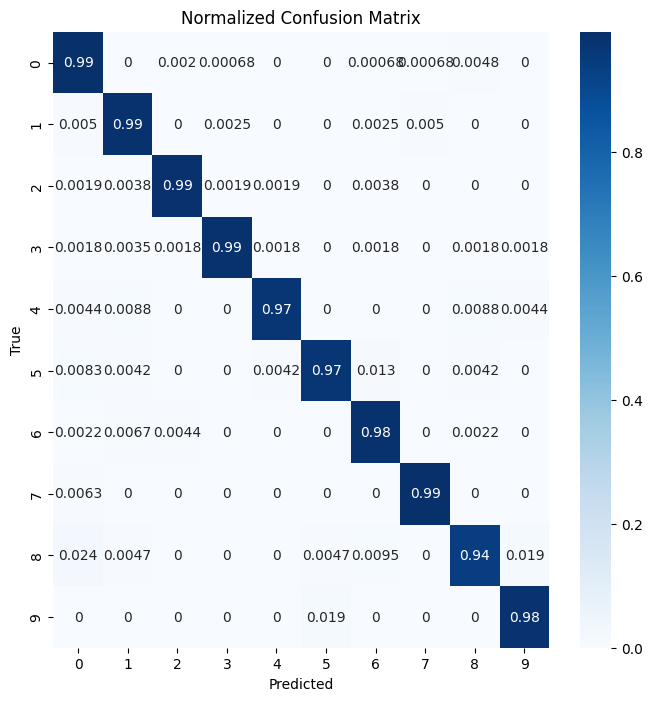

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(conf_mat_normalized, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

### Loss 시각화
 - 이 그래프는 학습 과정에서의 train loss와 validation loss의 변화를 보여줍니다.
 - x축은 에포크를, y축은 손실 값을 나타냅니다.
 - train loss는 모델이 훈련 데이터에 얼마나 잘 맞는지를 나타내며, validation loss는 모델이 보지 못한 데이터에 대한 성능을 나타냅니다.
 - 두 손실 모두 시간이 지남에 따라 안정적으로 감소하는 추세를 보이면, 이는 모델이 제대로 학습되고 있음을 의미합니다.
 - 급격한 변동이나 높은 손실 값이 지속되지 않는 것은 모델이 과적합 없이 일반화 능력을 갖추고 있음을 시사합니다.

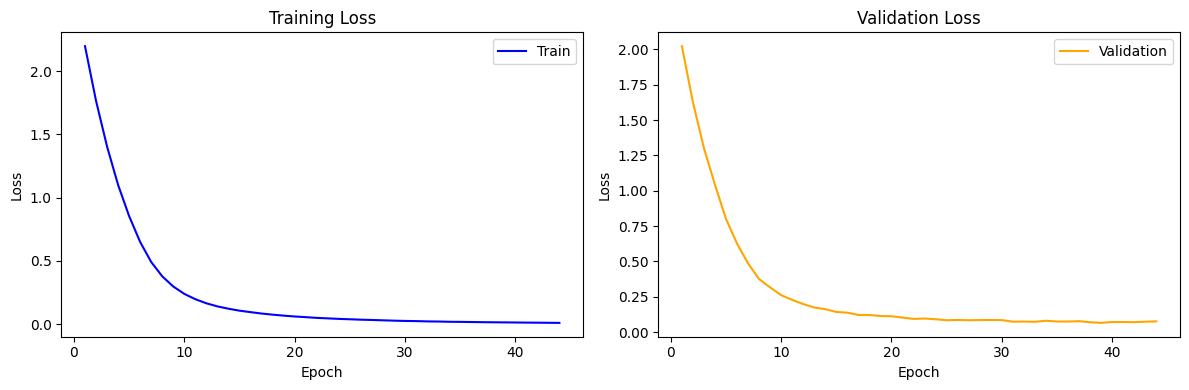

In [ ]:
actual_epochs = len(train_losses)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Train Loss 그래프
axes[0].plot(range(1, actual_epochs + 1), train_losses, label='Train', color='blue')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()

# Validation Loss 그래프
axes[1].plot(range(1, actual_epochs + 1), valid_losses, label='Validation', color='orange')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Validation Loss')
axes[1].legend()

# 그래프 출력
plt.tight_layout()
plt.show()